In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('error')


In [2]:
filepath = os.path.join(os.getcwd(), '../data/Interim_Report.csv')
df = pd.read_csv(filepath)
df['Class'] = df['Class'].apply(lambda val: 0 if val == 'Benign' else 1)
df = shuffle(df, random_state = 2)

In [3]:
X = df.drop('Class', axis=1)
y = df.loc[:,'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
random_state=1, stratify=y)

In [4]:
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (4414, 64)
X_test shape (2944, 64)
y_train shape (4414,)
y_test shape (2944,)


In [25]:
# Checking the range of parameters

max_depth = [3,4,5,6,7,8]
max_leaf_nodes= [4,6,8,10,12,14]
min_samples_split =  [10,20,30,40,50,60,70,80,90,100]
train_accuracy = []
test_accuracy = []

for par in min_samples_split:
    clf = DecisionTreeClassifier(criterion='gini', min_samples_split=par, random_state =1)
    #Fit the model
    clf.fit(X_train, y_train)
    #Compute accuracy on the training set and test set
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
  

In [26]:
train_loss = []
validation_loss = []

for score in train_accuracy:
    train_loss.append((1 - score))

for score in test_accuracy:
    validation_loss.append((1 - score))

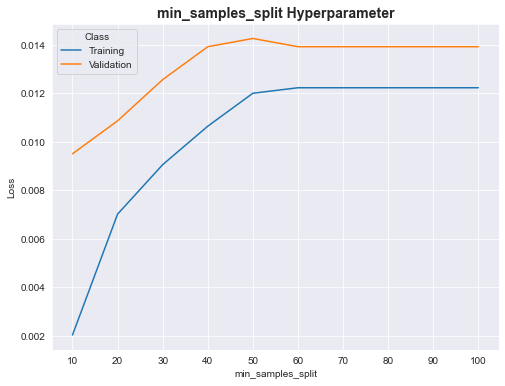

In [28]:
# # #Generate plot
x_ticks = np.arange(0, len(min_samples_split))
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,6));
sns.lineplot(data=[train_loss, validation_loss], dashes=False, ax=ax)
ax.set_title('min_samples_split Hyperparameter', fontsize=14, fontweight='bold');
ax.set(xlabel='min_samples_split', ylabel='Loss');
ax.legend(title='Class', labels=['Training', 'Validation']);
plt.xticks(ticks=x_ticks, labels=min_samples_split);
plt.savefig('../tuning/exp2_dt_min_samples_split.png', dpi=300)

In [27]:
# hyperparamer tuning
param_grid = {
    'criterion': ['gini'],
    'max_depth' : [4,5,6],
    'max_leaf_nodes': [4,6,8],
    'min_samples_split': [20,25,30],
    'max_features': ["sqrt"],      
    }
dt = DecisionTreeClassifier(random_state=99)
dtgrid = GridSearchCV(dt,param_grid,verbose =1,cv=5)
dtgrid.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=99),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 5, 6],
                         'max_features': ['sqrt'], 'max_leaf_nodes': [4, 6, 8],
                         'min_samples_split': [20, 25, 30]},
             verbose=1)

In [28]:
print(f'Best estimator:  {dtgrid.best_estimator_}')
print(f'Best score: {(dtgrid.best_score_ * 100):.3f} %')

Best estimator:  DecisionTreeClassifier(max_depth=6, max_features='sqrt', max_leaf_nodes=8,
                       min_samples_split=20, random_state=99)
Best score: 94.631 %


In [29]:
dt = DecisionTreeClassifier(
            criterion="gini", 
            max_depth=dtgrid.best_params_["max_depth"],
             max_leaf_nodes=dtgrid.best_params_["max_leaf_nodes"],
             min_samples_split = dtgrid.best_params_['min_samples_split'],
             max_features="sqrt",
             random_state=1
        ) 

In [30]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': 8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [31]:
# evaluating the models

In [32]:
def sensitivity(conf):
 return conf[1][1] / (conf[1][1] + conf[1][0])

def specificity(conf):
 return conf[0][0] / (conf[0][0] + conf[0][1])


In [33]:
def evaluate_model(X, y):

    train_accuracy = []
    test_accuracy = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrix_scores = []
    precision_scores = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
    for train, test in  cv.split(X,y):
        X_train_strat = X.iloc[train]
        y_train_strat = y.iloc[train]
        X_test_strat = X.iloc[test]
        y_test_strat = y.iloc[test]
     
        dt.fit(X_train_strat, y_train_strat)
   
        y_pred_train_strat = dt.predict(X_train_strat)
        y_pred_strat = dt.predict(X_test_strat)


        train_accuracy.append(accuracy_score(y_train_strat, y_pred_train_strat))
        test_accuracy.append(accuracy_score(y_test_strat, y_pred_strat))

        conf = confusion_matrix(y_test_strat,y_pred_strat)

        confusion_matrix_scores.append(conf) 

    
        precision_scores.append(precision_score(y_test_strat,y_pred_strat))
        sensitivity_scores.append(sensitivity(conf))
        specificity_scores.append(specificity(conf))

    return (train_accuracy, test_accuracy, confusion_matrix_scores, 
            precision_scores,sensitivity_scores, 
            specificity_scores)



In [34]:
train_accuracy, test_accuracy, confusion_matrix_scores, precision_scores, sensitivity_scores,specificity_scores = evaluate_model(X, y)

In [35]:
def average(array):
    total = 0
    for score in array:
        total += score

    return (f'{(total / 5 * 100):.2f}')

def score(array):
    for score in array:
        print(f'{(score * 100):.2f}') 

In [36]:
score(train_accuracy)
average(train_accuracy)


95.55
96.21
95.96
91.76
95.75


'95.05'

In [37]:
score(test_accuracy)
average(test_accuracy)

95.65
95.24
96.26
91.64
96.33


'95.03'

In [38]:
for cf in confusion_matrix_scores:
    print(cf , "\n")

[[729   7]
 [ 57 679]] 

[[730   6]
 [ 64 672]] 

[[727   9]
 [ 46 690]] 

[[649  86]
 [ 37 699]] 

[[723  13]
 [ 41 694]] 



In [39]:
# precision_scores
score(precision_scores)
average(precision_scores)

98.98
99.12
98.71
89.04
98.16


'96.80'

In [40]:
# sensitivity_scores
score(sensitivity_scores)
average(sensitivity_scores)

92.26
91.30
93.75
94.97
94.42


'93.34'

In [41]:
# specificity_scores
score(specificity_scores)
average(specificity_scores)

99.05
99.18
98.78
88.30
98.23


'96.71'

In [42]:
y_columns = y_train.apply(lambda val: 'Benign' if val == 0 else 'Malicious')
assert(len(y_train) == len(y_columns))

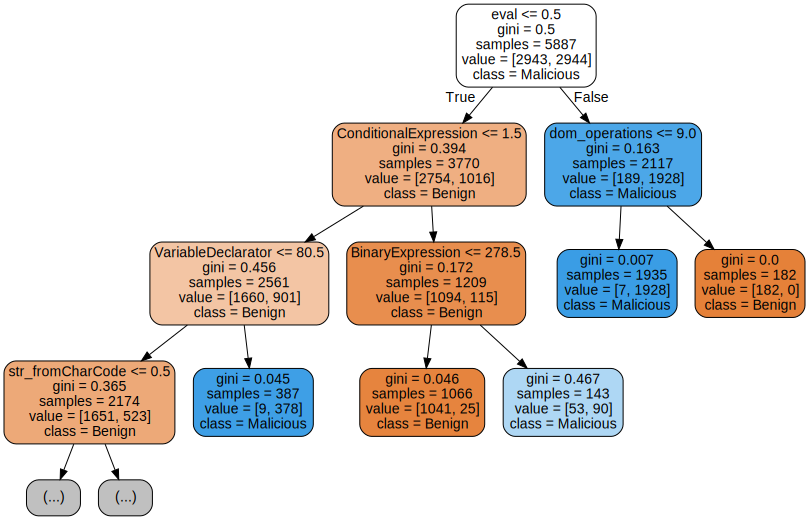

In [43]:
data = tree.export_graphviz(
    dt, 
    out_file=None, 
    feature_names = X_train.columns,
    class_names = sorted(y_columns.unique()),
    max_depth = 3,
    filled=True,
    rounded=True
);

graph = graphviz.Source(data);
graph

In [44]:
graph.render("tree",format="png", view=False)

'tree.png'